In [98]:
#from google.colab import drive
#drive.mount('/content/drive')

In [99]:
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
from datetime import timedelta
import datetime

# Please read, my idea was to classify the data into three cateogries: "UP", "DOWN", "NEUTRAL"
# UP - the price of the stock is up MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# DOWN - the price of the stock is down MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# NEUTRAL - the price of stock is did not rise or fall past the MINIMUM_GAIN threshhold
#
# EXAMPLE: LOOK_AHEAD_DAYS = 30, MINIMUM_GAIN = .05 (5%). If stock is up over 5% ore more after 30 days, 
# we mark it as 'UP'. If the stock is down 5% or more after 30 days, we mark it as 'DOWN'. If the stock
# is neither up nor down 5%, then we mark it as 'NEUTRAL'

# MINIMUM_GAIN = .05 #minimal gain to be considered up or down for classification, UNUSED NOW

LOOK_BACK_DAYS = 30 #number of days into the past we would like to take into account
LOOK_AHEAD_DAYS = 1 #number of days into the future we are trying to predict

class Utilities:

    @staticmethod
    def getData(ticker, start_date, end_date):
        try:
            stock_data = data.DataReader(ticker,
                                         'yahoo',
                                         start_date,
                                         end_date)
            return stock_data
        except RemoteDataError:
            print('No data found for {t}'.format(t=ticker))
#just get the btc price points from the past year
start_date = datetime.datetime.now() - timedelta(365)
end_date = datetime.datetime.now() - timedelta(1)
btc_df = Utilities.getData('BTC-USD', str(start_date.strftime('%Y-%m-%d')), str(end_date.strftime('%Y-%m-%d')))
btc_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-09,11915.655273,11323.898438,11861.556641,11354.024414,1.812536e+10,11354.024414
2019-08-10,11523.579102,11248.294922,11349.740234,11523.579102,1.577437e+10,11523.579102
2019-08-11,11528.189453,11320.951172,11528.189453,11382.616211,1.364720e+10,11382.616211
2019-08-12,11420.049805,10830.327148,11385.052734,10895.830078,1.668150e+10,10895.830078
2019-08-13,10889.556641,10028.135742,10889.487305,10051.704102,1.999084e+10,10051.704102
...,...,...,...,...,...,...
2020-08-04,11786.617188,11158.285156,11203.823242,11747.022461,2.441125e+10,11747.022461
2020-08-05,11902.335938,11598.713867,11749.871094,11779.773438,2.340074e+10,11779.773438
2020-08-06,11898.038086,11408.593750,11778.894531,11601.472656,2.313231e+10,11601.472656


In [100]:
def createLookBackCols():
    for i in range(LOOK_BACK_DAYS):
        num_rows= btc_df.shape[0]
        num_cols= btc_df.shape[1]
        btc_df.insert(loc = num_cols, column = 'High_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Low_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Open_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Volume_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Adj Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        
createLookBackCols() #create additional look back columns
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
    if (current_date - start_date).days >= LOOK_BACK_DAYS - 1:
        for i in range(LOOK_BACK_DAYS):
            index = i + 1
            look_back_date = current_date - timedelta(days=index)
            
            while True: #we need to keep subtracting days to the look_back_date because there is no index for that day
                if look_back_date in btc_df.index:
                    break
                look_back_date = look_back_date - timedelta(days=1)
            
            btc_df.at[pd.Timestamp(current_date), 'High_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'High']
            btc_df.at[pd.Timestamp(current_date), 'Low_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Low']
            btc_df.at[pd.Timestamp(current_date), 'Open_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Open']
            btc_df.at[pd.Timestamp(current_date), 'Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Close']
            btc_df.at[pd.Timestamp(current_date), 'Volume_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Volume']
            btc_df.at[pd.Timestamp(current_date), 'Adj Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Adj Close']

btc_df = btc_df[btc_df.High_Past_1 != 'N/A']
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,...,Close_Past_29,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-09,10394.353516,10020.573242,10336.408203,10115.975586,1.490681e+10,10115.975586,10335,1.75959e+10,10335,10443.2,...,11382.6,11528.2,11321,11528.2,11523.6,1.57744e+10,11523.6,11349.7,11248.3,11523.6
2019-09-10,10215.948242,9980.776367,10123.035156,10178.372070,1.542806e+10,10178.372070,10116,1.49068e+10,10116,10336.4,...,10895.8,11385.1,10830.3,11420,11382.6,1.36472e+10,11382.6,11528.2,11321,11528.2
2019-09-11,10442.253906,10099.242188,10176.819336,10410.126953,1.532356e+10,10410.126953,10178.4,1.54281e+10,10178.4,10123,...,10051.7,10889.5,10028.1,10889.6,10895.8,1.66815e+10,10895.8,11385.1,10830.3,11420
2019-09-12,10441.489258,10226.596680,10415.362305,10360.546875,1.410986e+10,10360.546875,10410.1,1.53236e+10,10410.1,10176.8,...,10311.5,10038.4,9675.32,10437.4,10051.7,1.99908e+10,10051.7,10889.5,10028.1,10889.6
2019-09-13,10422.133789,10291.694336,10345.403320,10358.048828,1.346871e+10,10358.048828,10360.5,1.41099e+10,10360.5,10415.4,...,10374.3,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-04,11786.617188,11158.285156,11203.823242,11747.022461,2.441125e+10,11747.022461,11246.3,2.02717e+10,11246.3,11043.8,...,9252.28,9349.16,9201.82,9360.62,9375.47,1.78893e+10,9375.47,9072.85,9058.66,9375.47
2020-08-05,11902.335938,11598.713867,11749.871094,11779.773438,2.340074e+10,11779.773438,11747,2.44113e+10,11747,11203.8,...,9428.33,9253.02,9249.5,9450.34,9252.28,1.38397e+10,9252.28,9349.16,9201.82,9360.62
2020-08-06,11898.038086,11408.593750,11778.894531,11601.472656,2.313231e+10,11601.472656,11779.8,2.34007e+10,11779.8,11749.9,...,9277.97,9427.99,9235,9431.38,9428.33,1.97024e+10,9428.33,9253.02,9249.5,9450.34


In [101]:
btc_df = btc_df.assign(MonthTrend=lambda x: "N/A") #introduce new column that will be the trend we are predicting
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

#Populate the classification column MonthTrend
for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
   
    if (end_date - current_date).days > LOOK_AHEAD_DAYS:
        look_ahead_date = current_date + timedelta(days=LOOK_AHEAD_DAYS)
        
        while True: #we need to keep adding days to the look_ahead_date because there is no index for that day
            if look_ahead_date in btc_df.index:
                break
            look_ahead_date = look_ahead_date + timedelta(days=1)
        
        #Here we check if the open price in the future is higher than today's open price.
        if btc_df.loc[pd.Timestamp(look_ahead_date)]['Open'] > btc_df.loc[index]['Open']:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'UP'
        else:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'DOWN'
            
#Now delete all columns that have a MonthTrend value of N/A
btc_df = btc_df[btc_df.MonthTrend != 'N/A']

#Data is now fully processed and ready to be trained on the machine learning model
#There are 3 values for MonthTrend: UP, DOWN,NEUTRAL
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,...,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-10,10215.948242,9980.776367,10123.035156,10178.372070,1.542806e+10,10178.372070,10116,1.49068e+10,10116,10336.4,...,11385.1,10830.3,11420,11382.6,1.36472e+10,11382.6,11528.2,11321,11528.2,DOWN
2019-09-11,10442.253906,10099.242188,10176.819336,10410.126953,1.532356e+10,10410.126953,10178.4,1.54281e+10,10178.4,10123,...,10889.5,10028.1,10889.6,10895.8,1.66815e+10,10895.8,11385.1,10830.3,11420,UP
2019-09-12,10441.489258,10226.596680,10415.362305,10360.546875,1.410986e+10,10360.546875,10410.1,1.53236e+10,10410.1,10176.8,...,10038.4,9675.32,10437.4,10051.7,1.99908e+10,10051.7,10889.5,10028.1,10889.6,UP
2019-09-13,10422.133789,10291.694336,10345.403320,10358.048828,1.346871e+10,10358.048828,10360.5,1.41099e+10,10360.5,10415.4,...,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4,DOWN
2019-09-14,10387.035156,10313.092773,10356.465820,10347.712891,1.204343e+10,10347.712891,10358,1.34687e+10,10358,10345.4,...,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3,UP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-02,11453.079102,11012.415039,11043.768555,11246.348633,2.027171e+10,11246.348633,11053.6,2.74101e+10,11053.6,11758.8,...,9126.09,8977.02,9162.18,9132.49,1.22905e+10,9132.49,9084.23,9053.63,9183.3,DOWN
2020-08-04,11786.617188,11158.285156,11203.823242,11747.022461,2.441125e+10,11747.022461,11246.3,2.02717e+10,11246.3,11043.8,...,9349.16,9201.82,9360.62,9375.47,1.78893e+10,9375.47,9072.85,9058.66,9375.47,UP
2020-08-05,11902.335938,11598.713867,11749.871094,11779.773438,2.340074e+10,11779.773438,11747,2.44113e+10,11747,11203.8,...,9253.02,9249.5,9450.34,9252.28,1.38397e+10,9252.28,9349.16,9201.82,9360.62,UP


In [102]:
def generateFeatures(features):
    complete_features = []
    for feature in features:
        complete_features.append(feature)
        for i in range(LOOK_BACK_DAYS):
            complete_features.append(feature + "_Past_" + str(i + 1))
    return complete_features

features = generateFeatures(['Close','Open'])
features.append('MonthTrend')

# selecting the important feature open close
btc = btc_df[features]
btc

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,...,Open_Past_22,Open_Past_23,Open_Past_24,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-10,10178.372070,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,...,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,11385.1,11528.2,DOWN
2019-09-11,10410.126953,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,...,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,11385.1,UP
2019-09-12,10360.546875,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,...,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,UP
2019-09-13,10358.048828,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,...,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,DOWN
2019-09-14,10347.712891,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,...,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,UP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-02,11246.348633,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,9905.17,9677.11,...,9241.05,9277.51,9273.36,9427.99,9253.02,9349.16,9072.85,9126.09,9084.23,DOWN
2020-08-04,11747.022461,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,...,9238.7,9277.21,9241.05,9277.51,9273.36,9427.99,9253.02,9349.16,9072.85,UP
2020-08-05,11779.773438,11747,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,...,9241.9,9238.7,9277.21,9241.05,9277.51,9273.36,9427.99,9253.02,9349.16,UP


In [103]:
# load pre-fetched news sentiment data and add in the dataframe
import pickle
import warnings
import os
warnings.filterwarnings('ignore')
f = open(os.path.join(os.getcwd(), "polaritys_score.pkl"), "rb")
#f = open("./drive/My Drive/final_project/polaritys_score.pkl", "rb")
polaritys_file = pickle.load(f)
f.close()

polaritys_df = pd.DataFrame(index=list(polaritys_file.keys())[::-1], columns=['neg', 'neu', 'pos'])
for date in list(polaritys_file.keys())[::-1]:
  for polar in ['neg', 'neu', 'pos']:
    polaritys_df.loc[date][polar] = polaritys_file[date][polar]

## keep data only after 2019-09-09 and remove data on 2020-08-03(error in Yahoo?)
btc_index_str = [btc_index.strftime('%Y-%m-%d') for btc_index in list(btc.index)]

sentiment_data = polaritys_df.loc[btc_index_str]
sentiment_data.columns = ['negative', 'neutral', 'positive']

## add sentiment in the dataframe
btc[['negative', 'neutral', 'positive']] = sentiment_data[['negative', 'neutral', 'positive']]
btc

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,...,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend,negative,neutral,positive
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-10,10178.372070,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,...,10358.7,10319.4,10038.4,10889.5,11385.1,11528.2,DOWN,0.0490984,0.869071,0.0818306
2019-09-11,10410.126953,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,...,10233,10358.7,10319.4,10038.4,10889.5,11385.1,UP,0.0484984,0.888504,0.0629979
2019-09-12,10360.546875,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,...,10350.3,10233,10358.7,10319.4,10038.4,10889.5,UP,0.0588,0.8413,0.0999
2019-09-13,10358.048828,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,...,10916.3,10350.3,10233,10358.7,10319.4,10038.4,DOWN,0.0439319,0.879837,0.0762308
2019-09-14,10347.712891,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,...,10764.6,10916.3,10350.3,10233,10358.7,10319.4,UP,0.0253,0.9104,0.0643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-02,11246.348633,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,9905.17,9677.11,...,9427.99,9253.02,9349.16,9072.85,9126.09,9084.23,DOWN,0.0587864,0.869428,0.0717857
2020-08-04,11747.022461,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,...,9277.51,9273.36,9427.99,9253.02,9349.16,9072.85,UP,0.05575,0.8895,0.05475
2020-08-05,11779.773438,11747,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,...,9241.05,9277.51,9273.36,9427.99,9253.02,9349.16,UP,0.022,0.902368,0.0756316


In [104]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
Y = btc['MonthTrend']
le =LabelEncoder()
Y = le.fit_transform(Y)
X = btc.drop(['MonthTrend'], axis=1)
X = StandardScaler().fit_transform(X)
# Create training and testing datasets that are appropriate for time series data
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=2)
train_size_perc = 0.7
n_time, n_features = X.shape
train_size = np.int16(np.round(train_size_perc * n_time))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[(train_size+LOOK_AHEAD_DAYS):], Y[(train_size+LOOK_AHEAD_DAYS):]

In [105]:
# decision tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=45)
param_grid = {'splitter': ["best","random"],  
              'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
             'max_leaf_nodes':[10,50,None]}  
grid =  GridSearchCV(model_tree,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
grid.fit(X_train,Y_train)
model_tree = grid.best_estimator_
tree_error_rate = 1 - model_tree.score(X_test,Y_test)
tree_error_rate

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done 5760 out of 5760 | elapsed:    2.7s finished


0.4387755102040817

In [106]:
model_tree.score(X_train, Y_train)

1.0

In [107]:
#confusion matrix and classification for testing
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, auc
import matplotlib.pylab as plt
prediction = model_tree.predict(X_test)
print(confusion_matrix(Y_test, prediction))

[[16 27]
 [16 39]]


In [108]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.50      0.37      0.43        43
           1       0.59      0.71      0.64        55

    accuracy                           0.56        98
   macro avg       0.55      0.54      0.54        98
weighted avg       0.55      0.56      0.55        98



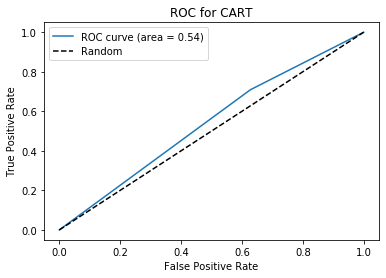

In [109]:
# Plot the ROC curve

def plot_roc(Y_test,Y_pred, classifier_name):
    fpr, tpr, _ = roc_curve(Y_test,Y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC for " + classifier_name)
    plt.legend(loc="best")
    plt.show()
plot_roc(Y_test,prediction, "CART")

In [13]:
# random forest
from sklearn.ensemble import RandomForestClassifier
model_random = RandomForestClassifier(random_state=42)
param_grid = {
             'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
              'min_samples_leaf':[1,2,4,6],
             'max_leaf_nodes':[10,50]}  
random_grid =  GridSearchCV(model_random,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
random_grid.fit(X_train,Y_train)
model_random = random_grid.best_estimator_
tree_error_rate =1 - model_random.score(X_test,Y_test)
tree_error_rate

Fitting 10 folds for each of 768 candidates, totalling 7680 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 764 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done 6764 tasks      | elapsed:   10.6s
[Parallel(n_jobs=6)]: Done 7680 out of 7680 | elapsed:   11.9s finished


0.3979591836734694

In [14]:
model_random.score(X_train, Y_train)

0.7931034482758621

In [15]:
new_prediction = model_random.predict(X_test)
print(confusion_matrix(Y_test, new_prediction))

[[28 15]
 [24 31]]


In [16]:
print(classification_report(Y_test, new_prediction))

              precision    recall  f1-score   support

           0       0.54      0.65      0.59        43
           1       0.67      0.56      0.61        55

    accuracy                           0.60        98
   macro avg       0.61      0.61      0.60        98
weighted avg       0.61      0.60      0.60        98



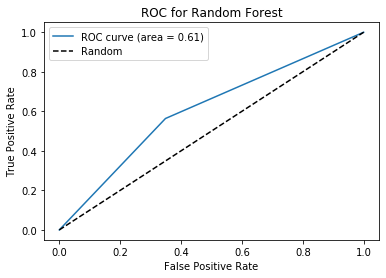

In [110]:
plot_roc(Y_test,new_prediction, "Random Forest")

In [18]:
# linear svm
from sklearn.svm import LinearSVC
model_svm = LinearSVC(random_state=42)
param_grid = {
             'C': [1,2,4,6,8,10],
             'loss':["hinge","squared_hinge"],
             'fit_intercept':[True,False],
              'class_weight':["balanced",None]}  
svm_grid =  GridSearchCV(model_svm,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
svm_grid.fit(X_train,Y_train)
model_svm = svm_grid.best_estimator_
svm_error_rate =1 - model_svm.score(X_test,Y_test)
svm_error_rate

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=6)]: Done 480 out of 480 | elapsed:    0.9s finished


0.08163265306122447

In [19]:
model_svm.score(X_train, Y_train)

0.9956896551724138

In [20]:
svm_prediction = model_svm.predict(X_test)
print(confusion_matrix(Y_test, svm_prediction))

[[41  2]
 [ 6 49]]


In [21]:
print(classification_report(Y_test, svm_prediction))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91        43
           1       0.96      0.89      0.92        55

    accuracy                           0.92        98
   macro avg       0.92      0.92      0.92        98
weighted avg       0.92      0.92      0.92        98



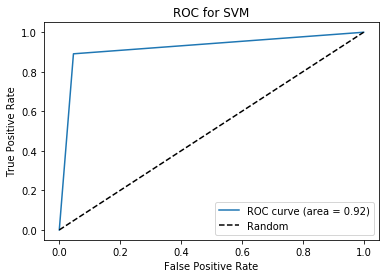

In [111]:
plot_roc(Y_test,svm_prediction, "SVM")

In [88]:
# logistic regression
from sklearn.linear_model import LogisticRegression
model_regression = LogisticRegression()
param_grid = {
             'C': [1,2,4,6,8,10],
             'penalty':["l1", "l2"],
             'fit_intercept':[True,False],
              'class_weight':["balanced",None],
              'warm_start':[True,False]}  
regression_grid =  GridSearchCV(model_regression,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
regression_grid.fit(X_train,Y_train)
model_regresssion= regression_grid.best_estimator_
regression_error_rate =1 - model_regresssion.score(X_test,Y_test)
regression_error_rate

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 960 out of 960 | elapsed:    3.8s finished


0.061224489795918324

In [89]:
regression_prediction = model_regresssion.predict(X_test)
print(confusion_matrix(Y_test, regression_prediction))

[[42  1]
 [ 5 50]]


In [90]:
print(classification_report(Y_test, regression_prediction))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        43
           1       0.98      0.91      0.94        55

    accuracy                           0.94        98
   macro avg       0.94      0.94      0.94        98
weighted avg       0.94      0.94      0.94        98



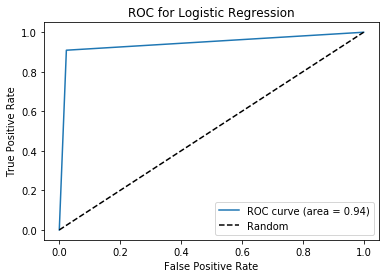

In [112]:
plot_roc(Y_test,regression_prediction, "Logistic Regression")

In [49]:
# install tensorflow in virtual enviroment locally or use google colab
# Please read this line at least.Basic model frame tuning may needed. I reached 0.7347 test accuracy for old dataset.
import tensorflow as tf
# Nerual network layer by layer. The input shape(...,62) may vary if new added
NN_model = tf.keras.models.Sequential()
NN_model.add(tf.keras.layers.Dense(units=128,activation="relu",input_dim=65)) 
# dropout exist for preventing overfitting. 
NN_model.add(tf.keras.layers.Dropout(0.2))
NN_model.add(tf.keras.layers.Dense(units=256,activation="relu"))
NN_model.add(tf.keras.layers.Dropout(0.2)) 
NN_model.add(tf.keras.layers.Dense(units=256,activation="relu")) 
# please do not change this line. sigmoid function is a must for binary classification
NN_model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
# you can play with this line
NN_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy']) 

In [50]:
# a basic summary of model
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               8448      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 107,521
Trainable params: 107,521
Non-trainable params: 0
________________________________________________

In [51]:
# I added early stop here.
earlyStopping=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
NN_model.fit(x=X_train,y=Y_train,batch_size=30,epochs=50,callbacks=[earlyStopping])

Train on 232 samples
Epoch 1/50
232/232 [==============================] - 1s 3ms/sample - loss: 0.7142 - accuracy: 0.4957
Epoch 2/50
232/232 [==============================] - 0s 99us/sample - loss: 0.6897 - accuracy: 0.5905
Epoch 3/50
232/232 [==============================] - 0s 69us/sample - loss: 0.6681 - accuracy: 0.6121
Epoch 4/50
232/232 [==============================] - 0s 60us/sample - loss: 0.6793 - accuracy: 0.5819
Epoch 5/50
232/232 [==============================] - 0s 67us/sample - loss: 0.6520 - accuracy: 0.6509
Epoch 6/50
232/232 [==============================] - 0s 104us/sample - loss: 0.6431 - accuracy: 0.6336
Epoch 7/50
232/232 [==============================] - 0s 65us/sample - loss: 0.6412 - accuracy: 0.6078
Epoch 8/50
232/232 [==============================] - 0s 67us/sample - loss: 0.6138 - accuracy: 0.6810
Epoch 9/50
232/232 [==============================] - 0s 69us/sample - loss: 0.6193 - accuracy: 0.6638
Epoch 10/50
232/232 [==============================]

In [52]:
test_loss, test_accuracy = NN_model.evaluate(X_test, Y_test)

98/98 [==============================] - 0s 1ms/sample - loss: 0.5493 - accuracy: 0.7245


In [53]:
NN_prediction = NN_model.predict_classes(X_test)
print(confusion_matrix(Y_test,NN_prediction))

[[36  7]
 [20 35]]


In [54]:
print(classification_report(Y_test,NN_prediction))

              precision    recall  f1-score   support

           0       0.64      0.84      0.73        43
           1       0.83      0.64      0.72        55

    accuracy                           0.72        98
   macro avg       0.74      0.74      0.72        98
weighted avg       0.75      0.72      0.72        98



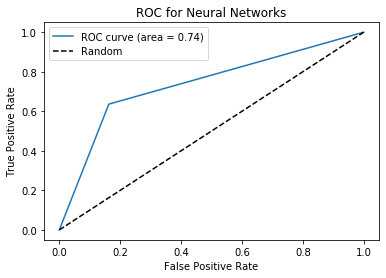

In [114]:
plot_roc(Y_test,NN_prediction, "Neural Networks")

### Backtesting

In [35]:
btc

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,...,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend,negative,neutral,positive
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-10,10178.372070,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,...,10358.7,10319.4,10038.4,10889.5,11385.1,11528.2,DOWN,0.0490984,0.869071,0.0818306
2019-09-11,10410.126953,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,...,10233,10358.7,10319.4,10038.4,10889.5,11385.1,UP,0.0484984,0.888504,0.0629979
2019-09-12,10360.546875,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,...,10350.3,10233,10358.7,10319.4,10038.4,10889.5,UP,0.0588,0.8413,0.0999
2019-09-13,10358.048828,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,...,10916.3,10350.3,10233,10358.7,10319.4,10038.4,DOWN,0.0439319,0.879837,0.0762308
2019-09-14,10347.712891,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,...,10764.6,10916.3,10350.3,10233,10358.7,10319.4,UP,0.0253,0.9104,0.0643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-02,11246.348633,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,9905.17,9677.11,...,9427.99,9253.02,9349.16,9072.85,9126.09,9084.23,DOWN,0.0587864,0.869428,0.0717857
2020-08-04,11747.022461,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,...,9277.51,9273.36,9427.99,9253.02,9349.16,9072.85,UP,0.05575,0.8895,0.05475
2020-08-05,11779.773438,11747,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,...,9241.05,9277.51,9273.36,9427.99,9253.02,9349.16,UP,0.022,0.902368,0.0756316


In [149]:
portfolio_value = 100
portfolio_value_history = []
for i in range(0, len(btc) - LOOK_BACK_DAYS - LOOK_AHEAD_DAYS - 1):
    portfolio_value_history.append(portfolio_value)
    train_df = btc[i: i + LOOK_BACK_DAYS]
    X_TRAIN = train_df.drop(['MonthTrend'], axis=1)
    Y_TRAIN = le.fit_transform(train_df['MonthTrend'])
    test_df = btc[i + LOOK_BACK_DAYS + LOOK_AHEAD_DAYS : i + LOOK_BACK_DAYS + LOOK_AHEAD_DAYS + 1]
    X_TEST = test_df.drop(['MonthTrend'], axis=1)
    results_df = btc[i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS : i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS + 1]
    
    model_regression = LogisticRegression()
    param_grid = {'C': [1,2,4]}  #simplified the CV so it runs faster
    regression_grid =  GridSearchCV(model_regression, param_grid, cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
    regression_grid.fit(X_TRAIN,Y_TRAIN)
    model_regresssion= regression_grid.best_estimator_
    
    prediction = model_regresssion.predict(X_TEST)[0]
    if prediction == 1:
        gains = ((results_df['Close'] - results_df['Open']) / results_df['Open'])[0]
        if gains > 0:
            print("G A I N! " + str(gains))
            portfolio_value = portfolio_value * (1 + gains)
        elif gains < 0:
            print("LOSS! " + str(gains))
            portfolio_value = portfolio_value * (1-gains)
    print("portfolio value: " + str(portfolio_value))

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 100
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.006472248446458507
portfolio value: 100.64722484464585
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 100.64722484464585
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 100.64722484464585
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 100.64722484464585
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.01576683387668956
portfolio value: 102.23411291892121
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.0018506645601594578
portfolio value: 102.4233139685396
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.02804156095277337
portfolio value: 105.29542357017344
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.0022620313782647896
portfolio value: 105.53360512227687
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.02004017417338013
portfolio value: 107.64851695007202
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.64851695007202
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.64851695007202
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.64851695007202
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.0666155602568345
portfolio value: 114.81958321751843
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.03354443193792408
portfolio value: 118.67114091189929
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 118.67114091189929
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 118.67114091189929
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 118.67114091189929
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 118.67114091189929
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 118.67114091189929
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 118.67114091189929
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 118.67114091189929
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 118.67114091189929
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.007487251939196074
portfolio value: 119.55966164181851
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.0021428022555042866
portfolio value: 119.81585435445193
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 119.81585435445193
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 119.81585435445193
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 119.81585435445193
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 119.81585435445193
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 119.81585435445193
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 119.81585435445193
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 119.81585435445193
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.011784219802174851
portfolio value: 121.22779071795017
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 121.22779071795017
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 121.22779071795017
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 121.22779071795017
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 121.22779071795017
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.01191904293019026
portfolio value: 122.67270995984954
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 122.67270995984954
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 122.67270995984954
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 122.67270995984954
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 122.67270995984954
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 122.67270995984954
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 122.67270995984954
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 122.67270995984954
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.04303944641881955
portfolio value: 127.95247548721787
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.009780564271446534
portfolio value: 129.2039228974113
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.03944386872045691
portfolio value: 134.30022547034483
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 134.30022547034483
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.01945736899024742
portfolio value: 136.91335451279477
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 136.91335451279477
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 136.91335451279477
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 136.91335451279477
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.026893618889021805
portfolio value: 140.59545008987942
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 140.59545008987942
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 140.59545008987942
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 140.59545008987942
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.02127748601577484
portfolio value: 143.5869678130484
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.016089291335703207
portfolio value: 145.89718037020276
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.008213396122211523
portfolio value: 147.095491705697
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.0036575395972403297
portfolio value: 147.6334992911861
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 147.6334992911861
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 147.6334992911861
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 147.6334992911861
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.030918791468149444
portfolio value: 152.19814866948346
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.0419545605619424
portfolio value: 158.58355511525284
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 158.58355511525284
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 158.58355511525284
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.0014121515478123844
portfolio value: 158.80749912806644
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 158.80749912806644
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 158.80749912806644
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 158.80749912806644
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.004332218791688667
portfolio value: 159.49548796005016
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 159.49548796005016
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 159.49548796005016
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 159.49548796005016
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 159.49548796005016
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.014349607801452797
portfolio value: 161.78418565837822
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.017152715661847798
portfolio value: 164.55922379356
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.013824208309372019
portfolio value: 166.83412478251074
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 166.83412478251074
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.03013946677558713
portfolio value: 171.86241634342738
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 171.86241634342738
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 171.86241634342738
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.00011682454672833615
portfolio value: 171.88249409231634
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 171.88249409231634
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 171.88249409231634
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.010055550357497443
portfolio value: 173.6108671672339
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.02514441588488342
portfolio value: 177.97621101342207
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 177.97621101342207
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.015272041730619227
portfolio value: 180.69427113507652
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.019821640007488397
portfolio value: 184.2759279289315
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.005565189955339802
portfolio value: 185.3014584720525
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.08436766818626286
portfolio value: 200.93491043485318
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.002077313737779336
portfolio value: 201.352315284699
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.01006473750332586
portfolio value: 203.37887348372638
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 203.37887348372638
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.001747094147382285
portfolio value: 203.734195523291
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.026304494082594658
portfolio value: 209.0933204638556
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 209.0933204638556
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 209.0933204638556
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.0072430733190441176
portfolio value: 210.60779871449768
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.03157997998871862
portfolio value: 217.2587887833696
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 217.2587887833696
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 217.2587887833696
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 217.2587887833696
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 217.2587887833696
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.050049279975455885
portfolio value: 228.1324347303169
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 228.1324347303169
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.02071449319526047
portfolio value: 232.85808249715626
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 232.85808249715626
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.0049770810194061646
portfolio value: 234.01703603976816
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 234.01703603976816
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 234.01703603976816
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 234.01703603976816
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 234.01703603976816
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 234.01703603976816
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.007191076354091455
portfolio value: 235.6998704140883
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.007357123540003175
portfolio value: 237.4339434790875
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.025626723407693067
portfolio value: 243.5185974762239
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.025599003237296965
portfolio value: 249.7524308413598
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.03574965521197911
portfolio value: 258.6809941322921
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 258.6809941322921
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.010614245380323534
portfolio value: 261.42669767923826
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 261.42669767923826
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 261.42669767923826
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 261.42669767923826
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 261.42669767923826
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.046512734007670434
portfolio value: 273.58636813089635
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 273.58636813089635
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.002165220194780572
portfolio value: 274.17874286019
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 274.17874286019
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.0025315991230832565
portfolio value: 274.87285352518296
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.02702976926881395
portfolio value: 282.30260333422916
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 282.30260333422916
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.032079307542367944
portfolio value: 291.358675366599
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 291.358675366599
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 291.358675366599
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 291.358675366599
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 291.358675366599
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 291.358675366599
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 291.358675366599
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 291.358675366599
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 291.358675366599
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 291.358675366599
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.004872857562691288
portfolio value: 292.77842469131485
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.023202779203168475
portfolio value: 299.5716978348789
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 299.5716978348789
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 299.5716978348789
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 299.5716978348789
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 299.5716978348789
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 299.5716978348789
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 299.5716978348789
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 299.5716978348789
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.03677092618748876
portfolio value: 310.58722662382587
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 310.58722662382587
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 310.58722662382587
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 310.58722662382587
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.1803052944381409
portfolio value: 366.5877479689604
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.0011506637707782504
portfolio value: 367.0095672093595
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.0034568603651841767
portfolio value: 368.2782680358889
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 368.2782680358889
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 368.2782680358889
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 368.2782680358889
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.008555606405730876
portfolio value: 371.4291119449882
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 371.4291119449882
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 371.4291119449882
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.0347999416531722
portfolio value: 384.35482336896337
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.0518093174448143
portfolio value: 404.2679844243315
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.0012499732343843324
portfolio value: 404.77330858438035
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 404.77330858438035
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.028281287899985498
portfolio value: 416.22081905868487
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.00941673440572232
portfolio value: 420.1402599658927
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.019165508230020882
portfolio value: 428.19246157603214
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.01040550993110594
portfolio value: 432.6480224873863
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.07126221215679036
portfolio value: 463.4794776550982
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 463.4794776550982
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.021564190366541315
portfolio value: 473.47403734223786
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.004889222928563087
portfolio value: 475.78895746169087
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 475.78895746169087
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.0012169631408627014
portfolio value: 476.36797508575125
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.016480432667871005
portfolio value: 484.218725424282
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 484.218725424282
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.0001247944975687192
portfolio value: 484.27915325683466
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 484.27915325683466
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.07173456669840768
portfolio value: 519.0187084767855
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 519.0187084767855
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.02331736295175777
portfolio value: 531.1208560810912
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.009846897545044107
portfolio value: 536.3507487349578
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.042426659878031486
portfolio value: 559.1063195268633
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 559.1063195268633
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 559.1063195268633
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.04330925400949711
portfolio value: 583.3207971375673
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.015700347923088585
portfolio value: 592.4791366034005
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.0025764080564745543
portfolio value: 594.0056046242386
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.014494849437019487
portfolio value: 602.6156264280125
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 602.6156264280125
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 602.6156264280125
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.12736804333860577
portfolio value: 679.3695996514167
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.01581284728489233
portfolio value: 690.1123673807031
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.022136422889992704
portfolio value: 705.3889865866563
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.013478214671685432
portfolio value: 714.8963707749139
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.009589181518739467
portfolio value: 721.7516418413626
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 721.7516418413626
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 721.7516418413626
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.029011602819717205
portfolio value: 742.690813808943
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.07445808973911401
portfolio value: 797.9901530719449
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.009409678779474046
portfolio value: 805.4989840815351
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.025100306755284862
portfolio value: 825.717255673052
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 825.717255673052
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 825.717255673052
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 825.717255673052
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 825.717255673052
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 825.717255673052
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 825.717255673052
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 825.717255673052
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 825.717255673052
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 825.717255673052
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.00020300159238786195
portfolio value: 825.8848775908159
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.020806252841098223
portfolio value: 843.0684471716098
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.046307943383057375
portfolio value: 882.1092130912748
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 882.1092130912748
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 882.1092130912748
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.045799182434966564
portfolio value: 922.5090938692069
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.013752068195373245
portfolio value: 935.1955018389483
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.008365506954851122
portfolio value: 943.0188863137275
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.03888445278280139
portfolio value: 979.6876596718836
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.03710481145692723
portfolio value: 1016.0387855706871
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.009364831696839082
portfolio value: 1025.5538177950173
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.02770445818962556
portfolio value: 1053.9662306613302
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1053.9662306613302
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.07435465143396805
portfolio value: 1132.3335223653266
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.062301639731773724
portfolio value: 1202.8797575319416
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.0128970124775533
portfolio value: 1218.3933127738273
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1218.3933127738273
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.013742821551781435
portfolio value: 1235.137474651162
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.0011613782227134217
portfolio value: 1236.571936416279
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.010965459157736597
portfolio value: 1250.131515480655
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.0011706666946826217
portfolio value: 1251.5950028098014
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1251.5950028098014
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1251.5950028098014
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.05555142199039078
portfolio value: 1321.122884971953
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.017182559759992968
portfolio value: 1343.823157893278
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1343.823157893278
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.009576904311842898
portfolio value: 1356.6928236884605
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.0068897027457263844
portfolio value: 1366.0400339609344
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.008859260694653714
portfolio value: 1378.142138741128
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1378.142138741128
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1378.142138741128
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.012993790771637733
portfolio value: 1396.0494293455076
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1396.0494293455076
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1396.0494293455076
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1396.0494293455076
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1396.0494293455076
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1396.0494293455076
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1396.0494293455076
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1396.0494293455076
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.013354705634473147
portfolio value: 1414.693258525591
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1414.693258525591
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1414.693258525591
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1414.693258525591
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1414.693258525591
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1414.693258525591
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1414.693258525591
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1414.693258525591
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1414.693258525591
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.033355011162898233
portfolio value: 1461.880367955789
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1461.880367955789
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.018946515881163382
portfolio value: 1489.5779075636246
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1489.5779075636246
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.0005877262208877541
portfolio value: 1490.4533715579548
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1490.4533715579548
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.003835634967937744
portfolio value: 1496.1702066279834
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.0036207909634017686
portfolio value: 1501.587526191853
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.00048824408864204085
portfolio value: 1502.3206674250946
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1502.3206674250946
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! -0.006500550114378745
portfolio value: 1512.0865782115582
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1512.0865782115582
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.0008585168499805567
portfolio value: 1513.3847300175823
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.0030368536409080254
portfolio value: 1517.9806579450308
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1517.9806579450308
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1517.9806579450308
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.01603007140980671
portfolio value: 1542.313996290595
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.005660739214126417
portfolio value: 1551.044633609893
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1551.044633609893
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.014427186018473996
portfolio value: 1573.4218430619387
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1573.4218430619387
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.10960438208121646
portfolio value: 1745.8757719238313
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1745.8757719238313
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.01718275945013738
portfolio value: 1775.8747353426215
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.0010253180716313212
portfolio value: 1777.6955718017218
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 1777.6955718017218
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 1777.6955718017218
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.05996806736995966
portfolio value: 1884.3005396148064
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.01834338315963851
portfolio value: 1918.8649864008744
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.04848337991486758
portfolio value: 2011.8980465418854
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 0.002544908238687459
portfolio value: 2017.0181424559291
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! -0.015062693237407877
portfolio value: 2047.399867990029
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 0.012882200489890527
portfolio value: 2073.774883572452


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


Text(0.5, 1.0, 'Trade Performance')

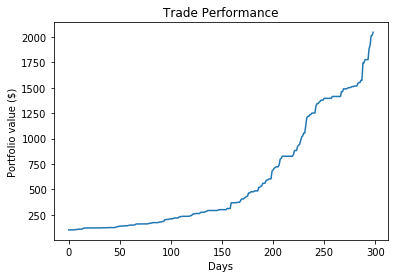

In [150]:
plt.plot(range(0, len(portfolio_value_history)), portfolio_value_history)
plt.xlabel('Days')
plt.ylabel('Portfolio value ($)')
plt.title("Trade Performance")